In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate


from pygsp import graphs, filters, plotting
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
import scipy
import matplotlib
from utils import *



import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

# Acquisition

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## Loading and sanity check

### genotype_BXD

In [36]:
# Load raw data
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

# Right formatting
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'
genotype_df.to_pickle("data/pickle/genotype_df.pkl")

# Genotype basic statistics
strains_qty = genotype_df.shape[0]
snp_qty = genotype_df.shape[1]
print("Quantity of strains: %i" % strains_qty)
print("Quantity of SNP: %i" % snp_qty)

# Check for NaN values
print("Is there nan values : %s" % genotype_df.isna().any().any())

Quantity of strains: 93
Quantity of SNP: 7324
Is there nan values : False


### Phenotype

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7847: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


Quantity of strains: 93
Quantity of phenotypes: 5092
Number of Nan values: 291981
Percentage of missing values: 61.66%


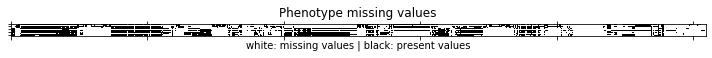

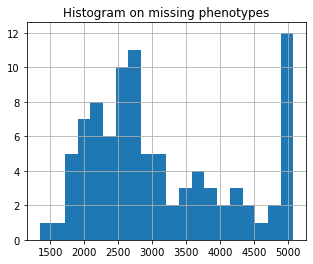

In [24]:
# Raw data loading
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')

# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

# Transpose to be consistant with genetics
phenotype_df = phenotype_df.T 

# Nan values checks
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

# Print a spy matrix to assess quantity of nan values
fig, ax1 = plt.subplots(figsize=(10, 1))
ax1.spy(phenotype_df)
ax1.set_title("Phenotype missing values")
ax1.set_xlabel("white: missing values | black: present values")
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tight_layout()
# fig.savefig("phenotype_missing_values.jpg")

# Histogram that shows the count of missing values of the phenotypes
fig, ax2 = plt.subplots(figsize=(5, 4))
phenotype_df.isnull().sum(axis=1).hist(bins=20, ax=ax2)
ax2.set_title("Histogram on missing phenotypes")

# Simple statistics
strains_qty = phenotype_df.shape[0]
phenotypes_qty = phenotype_df.shape[1]

print("Quantity of strains: %i" % strains_qty)
print("Quantity of phenotypes: %i" % phenotypes_qty)
print("Number of Nan values: %s" % nan_count)
print("Percentage of missing values: {:0.2f}%".format(nan_count / entries_count * 100))

plt.show()

In [61]:
# Find the phenotypes that are present in most of strains
top_phenotypes = strains_qty - phenotype_df.isna().sum(axis=0).sort_values()
top_phenotypes.head(15)

PhenoID
X546     93
X111     93
X152     93
X1012    92
X3820    92
X63      90
X4473    90
X62      90
X64      90
X2397    87
X1002    85
X416     85
X218     85
X328     85
X1302    84
dtype: int64

In [163]:
# The phenotype aligner allows to check to which phenotype the PhenoID corresponds to

# Load
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')

# Cleaning
phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)

# Since we want to stay as simple as possible, we decided to focus on classification task.
# Thus, we chose phenotype that are not *quantitative_trait*
def simplify_phenotype_show(row):
    """Helper function to show *phenotype shown* in a better format"""
    if row[0] == 'B':
        return row[:32]
    elif row[0] == 'H':
        return row[:30]
    elif row[0] == 'M':
        return row[:27]
    elif row[0] == 'G':
        return row[:33]
    elif row[0] == 'I':
        return row[:17]
    elif row[0] == 'A':
        return row[:13]
    
top_pheno_descr = phenotype_id_aligner.set_index('PhenoID').reindex(top_phenotypes.index)
top_pheno_descr[top_pheno_descr.quantitative_trait == 'No'].head(12).Shown_pheno\
            .apply(simplify_phenotype_show)

PhenoID
X546      BXD epoch or phase of production
X111      BXD epoch or phase of production
X152      BXD epoch or phase of production
X1012     BXD epoch or phase of production
X63         Hair coat color, ordinal scale
X4473          Mitochondrial strain origin
X62         Hair coat color, ordinal scale
X64         Hair coat color, ordinal scale
X76      GABRA2 receptor expression status
X65                      Iris pigmentation
X545                         Anxiety assay
X66                      Iris pigmentation
Name: Shown_pheno, dtype: object

In [ ]:
# As we see, there is many duplicates in of phenotype

In [ ]:
# For us, the best choice both in terms of amount of strains available for the phenotype
# and in terms of simplicity of phenotype, we chose one of the *Hair coat color* phenotype.
# Present the phenotype ....

### Gene Expression

In [16]:
#Gene expression
__file__ = "Graph_Analysis_Mice_Genetics.ipynb"
import os
import re

#__Build the dataframe for all the available gene expression files__#

# First create a list of all the files available
current_path = os.path.dirname(os.path.abspath(__file__))
expr_data_path = os.path.join(current_path, 'data/expression_data/')
files = os.listdir(expr_data_path)

# Then we concatenate all the table to a cat list that we will concatenate to get
# our final frame.
cat = []
for filename in files:
    df = pd.read_csv(os.path.join(expr_data_path, filename), sep='\t', index_col=None, header=0)
    cat.append(df)
frame = pd.concat(cat, axis=0, ignore_index=True, sort=False)


#__Cleaning basics__#

frame.set_index('gene', inplace=True)
# Remove F0 and F1 generation (parental)
frame.drop(['B6D2F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
# Proper formatting
gene_expression_df = frame.T


#__Basic statistics__#

strains_qty = gene_expression_df.shape[0]
gene_expression_qty = gene_expression_df.shape[1]
nan_count = gene_expression_df.isna().sum().sum()
entries_count = gene_expression_df.shape[0] * gene_expression_df.shape[1]

print("Quantity of gene expresion files: %i" % len(files))
print("Quantity of strains: %i" % strains_qty)
print("Quantity of phenotypes: %i" % gene_expression_qty)
print("Number of Nan entries: %s" % nan_count)
print("Percentage of missing entries: {:0.2f}%".format(nan_count / entries_count * 100))

Quantity of gene expresion files: 40
Quantity of strains: 94
Quantity of phenotypes: 1214846
Number of Nan entries: 63418214
Percentage of missing entries: 55.53%


In [20]:
# Saving file
gene_expression_df.to_pickle("data/pickle/gene_expression_df.pkl")

## Preprocessing

To build our graph, we chose as nodes the mice and as edges a gene based similarity

In [2]:
# Load cleaned data
genotype_df = pd.read_pickle("data/pickle/genotype_df.pkl")

In [3]:
# Build genetic strains distance with the all the 93 neighvors
genetic_distance, idx = distance_scipy_spatial(genotype_df.values, k=93, metric='cosine')

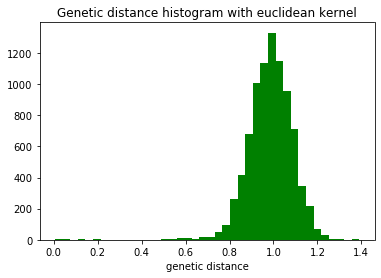

In [4]:
# Plot the genetic strains distance histogram
ax = plt.subplot()
plt.title("Genetic distance histogram with euclidean kernel")
plt.xlabel("genetic distance")
plt.hist(genetic_distance.flatten(), bins=40, color='g')
plt.show()

In [5]:
# The genetic distance between strain seems to be gaussian distributed around the value 1
#...

### Unweighted edges

In [27]:
# Build unweigthed adjacency matrix with 20 neighbors to make it sparser.
genetic_distance, idx = distance_scipy_spatial(genotype_df.values, k=20, metric='cosine')
adj = adjacency(genetic_distance, idx)

In [28]:
# Show relevant statistic to find a good threshold
median_sim = np.median(adj.toarray()[adj.nonzero()])
mean_sim = np.mean(adj[adj.nonzero()])
print("Median pairwise similarity: %0.2f" % median_sim)
print("Mean pairwise similarity: %0.2f" % mean_sim)

Median pairwise similarity: 0.40
Mean pairwise similarity: 0.41


In [29]:
# We see that the median and the mean are quite similar which could be an indicator of the godness of
# our similarity matrix

Let's create adjacency matrix for the strains by thresholding the Euclidean distance matrix.
The resulting **unweighted** adjacency matrix should have entries


$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$


In [30]:
# Algorithm to build the edges
threshold = mean_sim

idx_kept = np.where(adj.toarray() > threshold)
unweighted_adj = np.zeros(adj.shape)
unweighted_adj[idx_kept] = 1.

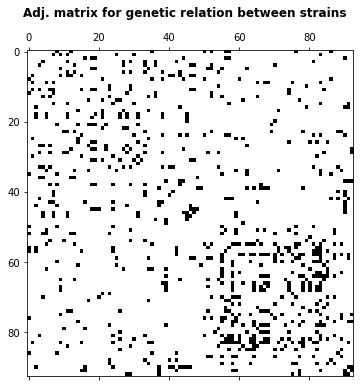

9.04 % of the original data is kept


In [31]:
# Plot the spied unweighted adjacency matrix
plt.figure(figsize=(6, 6))
plt.spy(unweighted_adj)
plt.suptitle("Adj. matrix for genetic relation between strains", fontweight='bold')
plt.show()
print_remaining_data(unweighted_adj)

In [32]:
# Save unweighted adjacency matrix
np.save("data/numpy/unweighted_adj.npy", unweighted_adj)

### Weighted edges

In [12]:
# Build genetic strains distance with a number of neighbors that keep ~10% of the data
genetic_distance_w, idx = distance_scipy_spatial(genotype_df.values, k=10, metric='cosine')
weighted_adj = adjacency(genetic_distance_w, idx)

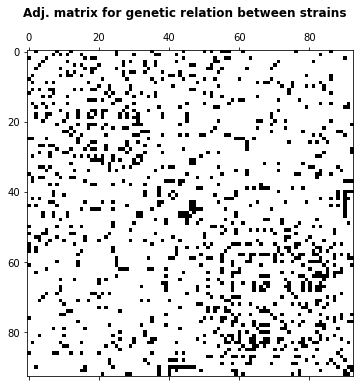

In [13]:
plt.figure(figsize=(6, 6))
plt.spy(weighted_adj.todense())
plt.suptitle("Adj. matrix for genetic relation between strains", fontweight='bold')
plt.show()

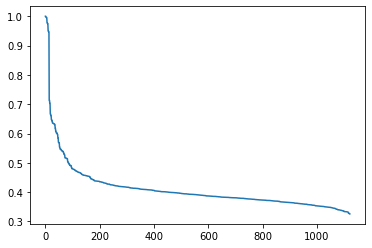

12.97 % of the original data is kept


In [16]:
plot_distrib(weighted_adj.toarray())
plt.show()
print_remaining_data(weighted_adj.toarray())

In [ ]:
# The edges weights seem to be quite smoothly distributed which is a nice of the goodness of th similarity graph

In [55]:
np.save("data/numpy/weighted_adj.npy", weighted_adj.toarray()) 

In [7]:
def build_adj_from_strain(genotype_df, strains, metric, k=4):
    """ Build adjacency matrix using whole data filtered by the strains parameter"""
    
    filtered_df = genotype_df[genotype_df.index.isin(strains)]
    filtered_df.sort_index(inplace=True)
    
    genetic_distance, idx = distance_scipy_spatial(genotype_df.values, k, metric='cosine')
    return adjacency(genetic_distance, idx)

In [51]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")
signal = gene_expression_df[signal.index]

In [11]:
adj = build_adj_from_strain(genotype_df, gene_expression_df.index, 'cosine', 10)

12.97 % of the original data is kept


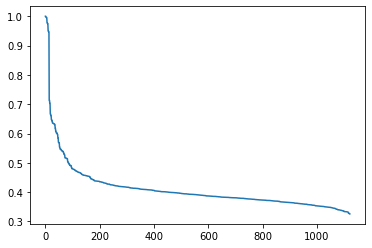

In [15]:
plot_distrib(adj.toarray())

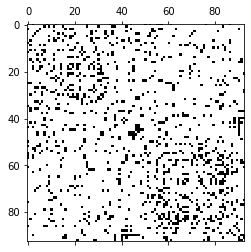

In [18]:
plt.spy(adj.toarray())
plt.show()

In [19]:
np.save("data/numpy/weighted_adjacency.npy", adj) 

# Exploration

## Gene graph

In [33]:
# Loading adjacency matrix
unweighted_adj = np.load("data/numpy/unweighted_adj.npy")
gene_graph = nx.from_numpy_array(unweighted_adj)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


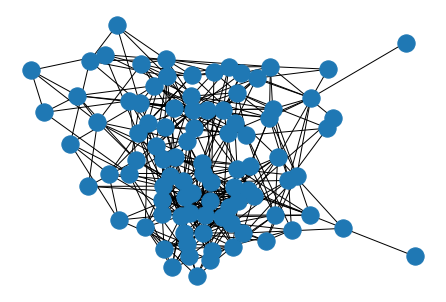

In [34]:
nx.draw(gene_graph)

### Basic statistics

In [36]:
graph_basic_stats(gene_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  93    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 391    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │   9.14 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.41 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.26 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


### Degree distribution

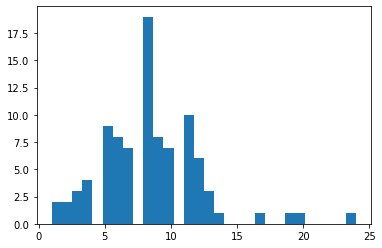

In [37]:
def plot_hist(G, bins=30):
    d = G.degree()
    plt.hist(list(dict(d).values()), bins=bins)
    plt.show()
    
plot_hist(gene_graph)

### Spectral analysis 

#### Eigenvalues & Eigenvectors

In [12]:
adjacency = np.load("data/numpy/weighted_adjacency.npy")
pygsp_weighted_graph = graphs.Graph(adjacency, 'normalized')
nx_weighted_graph = nx.Graph(adjacency)

In [13]:
pygsp_weighted_graph.compute_fourier_basis()

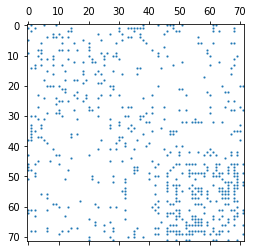

In [14]:
ax = plt.subplot()
ax.spy(pygsp_weighted_graph.W, markersize=1)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


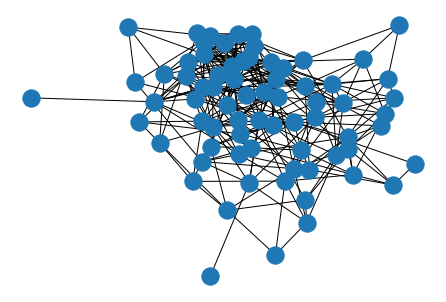

In [15]:
nx.draw(nx_weighted_graph)

In [1070]:
graph_basic_stats(nx_weighted_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  72    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 317    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  12.4  │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.81 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.27 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


In [16]:
# Laplacian
laplacian_matrix = nx.normalized_laplacian_matrix(nx_weighted_graph)
lamb_norm = nx.normalized_laplacian_spectrum(nx_weighted_graph)

Text(0.5, 1.0, 'Eigenvalues $L_{norm}$')

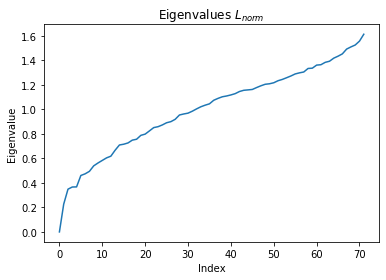

In [17]:
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

# Exploitation

## Preprocessing

### Labels (hait coat color)

In [18]:
# Build the target
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')

### Find interesting signal

In [199]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")

top_var = 30
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)

In [1075]:
top_var_gene.to_pickle("data/pickle/top_variance_genes.pkl")

### Graph signal processing (hand crafted)

In [19]:
lam = pygsp_weighted_graph.e
U = pygsp_weighted_graph.U

In [23]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")

In [24]:
signal

gene
Mup2_10513437        1.402106
Ube2g1_10342768      1.408469
Mup2_10513455        1.429377
Mup7_10513420        1.445048
Ube2g1_10343119      1.527340
Fbxw11_10375123      1.651943
Dlg1_10338109        1.656102
Fbxw11_10375121      1.680768
H2-Ea-ps_10450161    1.709376
Mela_10582545        1.813001
dtype: float64

In [25]:
signal = gene_expression_df.loc[:, signal.index]
# signal.replace({np.nan: 0}, inplace=True)

KeyError: "None of [Index(['Mup2_10513437', 'Ube2g1_10342768', 'Mup2_10513455', 'Mup7_10513420',\n       'Ube2g1_10343119', 'Fbxw11_10375123', 'Dlg1_10338109',\n       'Fbxw11_10375121', 'H2-Ea-ps_10450161', 'Mela_10582545'],\n      dtype='object', name='gene')] are in the [columns]"

In [22]:
signal

gene,Copg_1415670_at,Atp6v0d1_1415671_at,Golga7_1415672_at,Psph_1415673_at,Trappc4_1415674_a_at,Dpm2_1415675_at,Psmb5_1415676_a_at,Dhrs1_1415677_at,Ppm1a_1415678_at,Psenen_1415679_at,...,AFFX-r2-P1-cre-3_AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_AFFX-ThrX-3_at,AFFX-ThrX-5_AFFX-ThrX-5_at,AFFX-ThrX-M_AFFX-ThrX-M_at,Tfrc_AFFX-TransRecMur-X57349_3_at,Tfrc_AFFX-TransRecMur-X57349_5_at,Tfrc_AFFX-TransRecMur-X57349_M_at,AFFX-TrpnX-3_AFFX-TrpnX-3_at,AFFX-TrpnX-5_AFFX-TrpnX-5_at,AFFX-TrpnX-M_AFFX-TrpnX-M_at
gene,,,,,,,,,,,,,,,,,,,,,
Mup2_10513437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ube2g1_10342768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mup2_10513455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mup7_10513420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ube2g1_10343119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fbxw11_10375123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dlg1_10338109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fbxw11_10375121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H2-Ea-ps_10450161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'GFT')

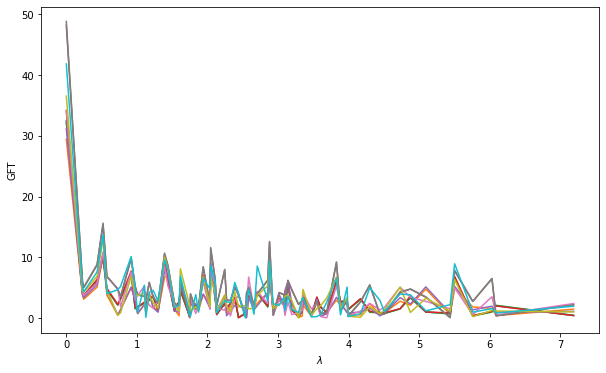

In [1079]:
plt.figure(figsize=(10, 6))
for i in range(signal.shape[1]):
    plt.plot(lam, abs(pygsp_weighted_graph.gft(signal.iloc[:, i].values)), '-') 
    
plt.xlabel('$\lambda$')
plt.ylabel('GFT')

In [1086]:
sign_filtered = filters.Expwin(pygsp_weighted_graph, bmax=0.2).filter(signal)

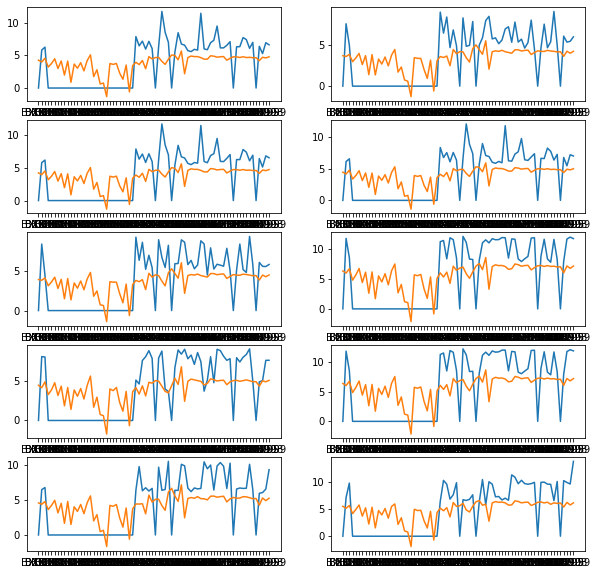

In [1087]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.plot(signal.iloc[:,idx])
    ax.plot(sign_filtered[:, idx])

In [126]:
fig.savefig("filtered_signal.png")

### Interpolation error measure

In [755]:
def kfold_interp_error(val, filter_, k=10, test_size=0.1):
    ''' Compute the error of interpolation with kfold for each column of the DataFrame
    
    Args:
        - df (pd.DataFrame): dataframe where rows are mouse strains and column are gene expression
        - filter_ (pygsp.filters): any pygsp filter
        - k (integer): the number of folding for each column
        - test_size (float): percentage of the strains to use as test set for error measurment
    Return:
        - kFold_abs_err_list (list()): the list of k-folded absolute error for each column (gene expression)
    '''
    
    kFold_abs_err_list = []
    
    for i in range(val.shape[1]):
        
        err_list = []
        non_zero_idx = np.where(val[:,i] != 0.)
        for j in range(k):
            s_copy = np.copy(val[:,i])
            idx_test = np.random.choice(non_zero_idx[0], size=int(s.shape[0] * test_size), replace=False)

            np.put(s_copy, idx_test, 0.)

            s_filtered = filter_.filter(s_copy)
            err = val[idx_test,i].sum() - s_filtered[idx_test].sum()
            err_list.append(err)
        
        kFold_abs_err_list.append(np.mean(err_list))
    return kFold_abs_err_list

In [818]:
pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
%time kFold_abs_err_list = kfold_interp_error(signal.values, pygsp_filter, test_size=0.1)

mean_err = np.mean(kFold_abs_err_list)
print("Mean absolute interpolation error for the gene expression: {}".format(mean_err))

CPU times: user 522 ms, sys: 7.87 ms, total: 530 ms
Wall time: 536 ms
Mean absolute interpolation error for the gene expression: 25.063579600767813


In [779]:
%%time
# find the best parameters for Expwin

mean_err_list = []
for i in np.linspace(0.01, 1.2, num=10):
    pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
    assess = []
    for j in range(50):
        assess.append(kfold_interp_error(signal.values, pygsp_filter, test_size=0.1))
    
    mean_err_list.append(np.mean(np.mean(assess)))

## Collective classification

In [3]:
adjacency = np.load("data/numpy/weighted_adjacency.npy")
genotype_gene_expression_present_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
pygsp_weighted_graph = graphs.Graph(adjacency, 'normalized')
nx_weighted_graph = nx.Graph(adjacency)

In [4]:
# Set strain name to node
strains_list = genotype_gene_expression_present_df.index.tolist()
mapping = dict(zip(range(len(strains_list)), strains_list))

In [5]:
nx.set_node_attributes(nx_weighted_graph, mapping, name='strain')

**Markov Assumption**:\
the label $Y_i$ of one node $i$ depends on the labels of its neighbors $N_i$:\
$P(Y_i|i) = P(Y_i|N_i)$ 

### Probabilistic relational classifier

**Basic idea:** Class probability of 𝑌𝑖 is a weighted
average of class probabilities of its neighbors\
**Labeled nodes:** initialize with ground-truth 𝑌
labels\
**Unlabeled nodes:** initialize 𝑌 uniformly\
**Update:** all nodes in a random order until
convergence or until maximum number of iterations
is reached

#### Node labelling

In [245]:
# Build the target
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')
y = y[genotype_gene_expression_present_df.index]

#### relational_classifier()

In [312]:
def masking(y, prop=0.5, rs=None):
    ''' Set to np.nan masked values
    
    Params:
        - y (pd.Series): the gene expression to create train/test 
        - prop (float): the proportion of nodes to mask as test set
        
    Returns:
        - tmp (pd.Series): the masked to np.nan series
        - mask (np.ndarray): the mask that created the series
    '''
    
    tmp = y.values.astype('float').copy()
    # random label masking
    m = None
    if rs is None:
        m = np.random.uniform(0, 1, len(nx_weighted_graph.node)) > prop
    else:
        rs = np.random.RandomState(42)
        m = rs.uniform(0, 1, len(nx_weighted_graph.node)) > prop
    tmp[~m] = np.nan
    return tmp, m

def init(y_masked, cat=4):
    ''' Initialize the probabilities for each node (1 for non-nan nodes and 1/#cat for np.nan ones)
    
    Params:
        - y_masked (pd.Series): a masked series
        
    Returns:
        - prob_mat (np.ndarray): a probability matrix that initialized to 
            1 for not masked data at the mouse label and 1/(# of categories) for the
            the masked data.
        
    '''
    
    a = y_masked.copy()
    # Unique categories

    # Probabily matrix
    prob_mat = np.zeros((a.shape[0], cat), dtype='float')
    # Vector to fill nan values
    nan_unif_val = np.array([1 / cat] * cat)
    # Replace nan values
    prob_mat[np.isnan(a), :] = nan_unif_val
    # One hot encode non-nan values to get a probability of one
    valid_val = ~np.isnan(a)
    a[valid_val] = a[valid_val]
    b = np.zeros((a[valid_val].shape[0], cat))
    b[np.arange(a[valid_val].shape[0], dtype='int'), a[valid_val].astype('int')-1] = 1
    prob_mat[valid_val, : ] = b
    
    return prob_mat

def update(G, p_m, max_iter):
    ''' Update the label probability matrix for each masked node and let to 1 for the training
        mice.
    
    Parameters:
        - G (nx.Graph): a graph
        - p_m (np.ndarray): a node label probability matrix
        - max_iter (int): the number of iteration of the update step
    
    '''
    
    p_mat = p_m
    proba_dict = dict(enumerate(p_mat))
    nx.set_node_attributes(G, proba_dict, name='probabilities')
    G_nodes = G.nodes
    G_edges = G.edges
    for i in range(max_iter):
        update_counter = 0
        for node in G.nodes():
            p_update = {}
            update_step(G, G_nodes, G_edges, node, p_update)
            nx.set_node_attributes(G, p_update, name='probabilities')
        if update_counter >= max_iter:
            break

def update_step(G, G_nodes, G_edges, node, p_update):
    """ Update the probability matrix accoring to nodes first neighbors"""
    if G_nodes[node]['probabilities'].max() != 1.: 
        W = 0
        sum_W_x_P = 0
        for neighbor in G.neighbors(node):
            W_ij = G.edges[node, neighbor]['weight']
            W += W_ij
            sum_W_x_P += W_ij * G_nodes[neighbor]['probabilities']
        p_update[node] = sum_W_x_P / W
    else: 
        p_update[node] = G_nodes[node]['probabilities']
    return p_update

In [27]:
from sklearn.metrics import classification_report, accuracy_score
def relational_classifier(G, y_masked, max_iter=100):
    """ classify the set where there is nan values
    
    Parameters:
        - G (nx.Graph): a Graph
        - y (pd.Series): the label to predict
        - max_iter (int): the number of iteration of the update
        - prop (float): percentage of test set
    """
    G_cop = G.copy()
    p_mat = init(y_masked)
    proba_dict = dict(enumerate(p_mat))
    nx.set_node_attributes(G, proba_dict, name='probabilities')
    update(G, p_mat, max_iter=100)
    updated_p_mat = np.concatenate(list(nx.get_node_attributes(G, 'probabilities').values())).reshape(-1, 4)
    y_pred = np.argmax(updated_p_mat, axis=1) + 1
    return y_pred



In [1]:
%load_ext line_profiler

In [80]:
def bootstrap_classification(div=10, boot_num=1):
    """ Run the classification process """
    scores = []
    for p in np.linspace(0, 0.8, div):
        bootstrap = []
        for i in range(boot_num):
            y_masked, mask = masking(y, p)
            y_pred = relational_classifier(nx_weighted_graph, y_masked, 100)
            acc_score = accuracy_score(y[~mask], y_pred[~mask])
            bootstrap.append(acc_score)
        scores.append(np.mean(bootstrap))
    return scores       
                      

In [316]:
scores = bootstrap_classification(div=40, boot_num=10)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [320]:
with open('data/results/relational_classifier_scorre.csv', 'w') as filehandle:
    for score in scores:
        filehandle.write('%s\n' % score)

In [340]:
scores = []
with open('data/results/relational_classifier_scorre.csv', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        if line[:-1] != 'nan':
            currentPlace = float(line[:-1])

            # add item to the list
            scores.append(currentPlace)

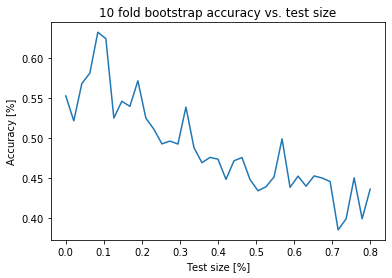

In [344]:
plt.plot(np.linspace(0, 0.8, 39), scores)
plt.title("10 fold bootstrap accuracy vs. test size")
plt.xlabel("Test size [%]")
plt.ylabel("Accuracy [%]")
plt.show()

As we can see, with the genetic graph, we are already able to predict 55% with 80% of the data as model and prediction on 20%. If the choice was random, we would have 25% (one out of four) of correct prediction. It means that this simple algorithm is already able to learn some patterns.

### Graph Convolutional Network (GCN)

In [2]:
gcn_message = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [3]:
# # Define the message and reduce function
# def gcn_message(edges):
#     # The argument is a batch of edges.
#     # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
#     return {'msg' : edges.src['h']}

# def gcn_reduce(nodes):
#     # The argument is a batch of nodes.
#     # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
#     return {'h' : th.sum(nodes.mailbox['msg'], dim=1)}

In [4]:
# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [5]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs.float())
        h = th.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 30 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.

In [6]:
# Build the target
genotype_gene_expression_present_df = pd.read_pickle("data/pickle/genotype_gene_expression_present_df.pkl")
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')
y = y[genotype_gene_expression_present_df.index]

In [7]:
# Build the relevant high variance signals
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
top_var = 30
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)
signal = gene_expression_df[top_var_gene.index]

In [8]:
# What are the most present labels ?
y.value_counts()

1    25
4    17
3    16
2    14
Name: X62, dtype: int64

In [9]:
# Select only the mice that have label 1 or 4. We chose it because they are the most present
y_binary = y[(y.values == 1) | (y.values == 4)]

In [10]:
# Drop the rows with only nan values
sign = signal[signal.index.isin(y_binary.index)].dropna(how='all')

In [11]:
# Filter y_binary to take into account nan filtering
y_binary = y_binary[y_binary.index.isin(sign.index)]

In [12]:
# Are both index the same ?
(y_binary.index == sign.index).all()

True

In [13]:
# Transfrom to np.array
sign_np = sign.values
y_b = y_binary.values

In [14]:
inputs = th.tensor(sign_np)

In [15]:
import random
# Select randomly which node to use as first labeled nodes 
# !!! idea: chose the best one based on graph properties !!!

one_node_labeled = np.random.choice(np.where(y_b == 1)[0])
four_node_labeled = np.random.choice(np.where(y_b == 4)[0])
print(one_node_labeled, four_node_labeled)
print("y_b[one_node_labeled]: %i, y_b[four_node_labeled]: %i" % (y_b[one_node_labeled], y_b[four_node_labeled]))

3 1
y_b[one_node_labeled]: 1, y_b[four_node_labeled]: 4


In [16]:
# Assign the labels both randomely selected nodes
labeled_nodes = th.tensor([one_node_labeled, four_node_labeled]) ## 
labels = th.tensor([0, 1])

In [17]:
# Build a graph adjacency for the subsample and mice labeled as 1 and 4
genotype_df = pd.read_pickle('data/pickle/genotype_df.pkl')
adj = utils.build_adj_from_strain(genotype_df, sign.index, 'cosine', 70, 0.273)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


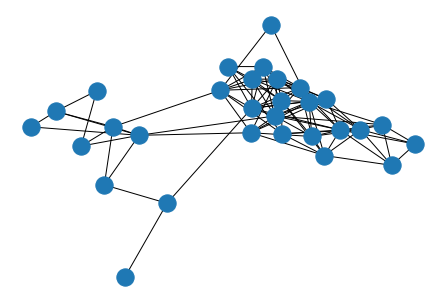

In [18]:
nx.draw(nx.from_numpy_array(adj))

In [20]:
utils.graph_basic_stats(nx.from_numpy_array(adj))

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  30    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 106    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  24.37 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   7.07 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.49 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


In [21]:
G = DGLGraph(adj)

In [36]:
net = GCN(sign_np.shape[1], 2, 2)

In [47]:
logits = net(G, inputs)
all_logits.append(logits.detach())
logp = F.log_softmax(logits, 1)
logp
# we only compute loss for labeled nodes
# loss = F.nll_loss(logp[labeled_nodes], labels)

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

tensor([[-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389]], grad_fn=<LogSoftmaxBackward>)

In [38]:
optimizer = th.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 12.6219
Epoch 1 | Loss: 56.2387
Epoch 2 | Loss: 13.5176
Epoch 3 | Loss: 15.9784
Epoch 4 | Loss: 20.6892
Epoch 5 | Loss: 22.4937
Epoch 6 | Loss: 22.4191
Epoch 7 | Loss: 20.9773
Epoch 8 | Loss: 18.5908
Epoch 9 | Loss: 15.6004
Epoch 10 | Loss: 12.2780
Epoch 11 | Loss: 8.8368
Epoch 12 | Loss: 5.4388
Epoch 13 | Loss: 2.2040
Epoch 14 | Loss: 0.5182
Epoch 15 | Loss: 0.7299
Epoch 16 | Loss: 0.7317
Epoch 17 | Loss: 0.7332
Epoch 18 | Loss: 0.7345
Epoch 19 | Loss: 0.7356
Epoch 20 | Loss: 0.7365
Epoch 21 | Loss: 0.7372
Epoch 22 | Loss: 0.7377
Epoch 23 | Loss: 0.7380
Epoch 24 | Loss: 0.7382
Epoch 25 | Loss: 0.7383
Epoch 26 | Loss: 0.7382
Epoch 27 | Loss: 0.7381
Epoch 28 | Loss: 0.7378
Epoch 29 | Loss: 0.7374


/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


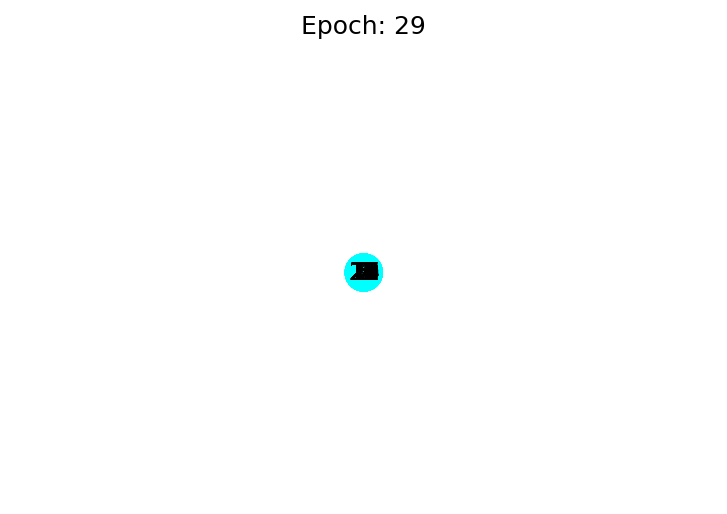

In [26]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

nx_G = G.to_networkx().to_undirected()

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(30):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(29)  # draw the prediction of the first epoch
# plt.close()

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


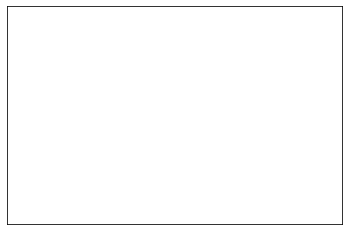

In [27]:
from IPython.display import HTML
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_jshtml())

SyntaxError: 'return' outside function (<ipython-input-39-fb00a25b1075>, line 13)

In [45]:
train_mask

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)